In [144]:
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import numpy as np
import corner
from copy import deepcopy
import glob
from tqdm import tqdm
from scipy.special import logsumexp
import os 

import sys
sys.path.append('../')
from populations import bbh_models, gw_obs
import populations.bbh_models as read_models
from populations.bbh_models import read_hdf5
from sample import sample

In [174]:
params = ['mchirp','q', 'chieff', 'z']
chi_b = [0.0,0.1,0.2,0.5]
alpha = [0.2,0.5,1.,2.,5.]
channels =['CE', 'CHE', 'GC', 'NSC', 'SMT']
file_path='/Users/stormcolloms/Documents/PhD/Project_work/OneChannel_Flows/models_reduced.hdf5'
gw_path = '/Users/stormcolloms/Documents/PhD/Project_work/AMAZE_model_selection/gwtc3_events/events_processed/events_processed'
np.random.seed(314)
observations, obsdata, p_theta, events = gw_obs.generate_observations(params, gw_path, \
                                            10000, 'posteriors', 'p_theta_jcb')

model_names, flow = read_models.get_models(file_path, channels, params, use_flows=True, use_unityweights=False, device='cpu',\
     no_bins=[5,4,4,5,4])
flow_path="/Users/stormcolloms/Documents/PhD/Project_work/AMAZE_model_selection/rns/Flows_150124_extralong/flow_models/"
for chnl in channels: flow[chnl].load_model(flow_path, chnl)

100%|██████████| 5/5 [00:06<00:00,  1.32s/it]


In [173]:
_posterior_key = "combined"
_events_to_use = pd.read_csv('/Users/stormcolloms/Documents/PhD/Project_work/AMAZE_model_selection/gwtc3_events/events_processed/events_processed/gwnames.csv',\
     dtype=str)
_events_to_use = np.reshape(np.array(_events_to_use),-1).tolist()
gw_names = _events_to_use
gw_files = [gw+'.hdf5' for gw in gw_names]
for gw in gw_files:
    df = pd.read_hdf(os.path.join(gw_path,gw), key=_posterior_key)
    print(gw)
    print(np.min(df['p_theta_jcb']))
    print(np.min(df['p_theta_jcb'][df['p_theta_jcb']>0]))

GW200311_115853.hdf5
4.381132150025236e-05
4.381132150025236e-05
GW190706_222641.hdf5
6.6232630829344e-05
6.6232630829344e-05
GW190503_185404.hdf5
4.689951356315839e-05
4.689951356315839e-05
GW200316_215756.hdf5
0.0032140386620598278
0.0032140386620598278
GW190602_175927.hdf5
7.74796555562882e-05
7.74796555562882e-05
GW190519_153544.hdf5
4.9240326165139e-05
4.9240326165139e-05
GW190719_215514.hdf5
2.030741836577962e-06
2.030741836577962e-06
GW170809_082821.hdf5
0.0003754522252041793
0.0003754522252041793
GW190413_134308.hdf5
4.04837536393459e-06
4.04837536393459e-06
GW190910_112807.hdf5
1.773552662111602e-05
1.773552662111602e-05
GW191230_180458.hdf5
1.577617640588711e-05
1.577617640588711e-05
GW190727_060333.hdf5
3.6223965585170396e-05
3.6223965585170396e-05
GW170729_185629.hdf5
7.618788133885049e-05
7.618788133885049e-05
GW200112_155838.hdf5
0.0
0.0007386659049777891
GW191127_050227.hdf5
2.2859091072920956e-05
2.2859091072920956e-05
GW190513_205428.hdf5
0.0001363620103351385
0.000136

In [175]:
np.min(p_theta[13,:])

0.0

In [68]:
filename='/Users/stormcolloms/Documents/PhD/Project_work/AMAZE_model_selection/rns/Flows_260624_contGwtc310000Nsamp/output_seed12_highreg.hdf5'
result_file = h5py.File(filename, 'r')
hyperpost_samps = np.array(result_file['model_selection']['samples']['block0_values'])

(array([ 3.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  5., 40.]),
 array([0.83281284, 1.24925661, 1.66570039, 2.08214416, 2.49858793,
        2.91503171, 3.33147548, 3.74791925, 4.16436303, 4.5808068 ,
        4.99725058]),
 <BarContainer object of 10 artists>)

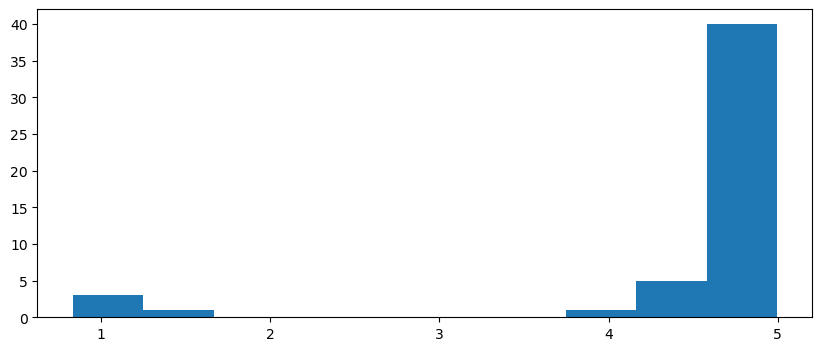

In [69]:
random_samp_idxs=np.random.choice(hyperpost_samps.shape[0],50)
plt.hist(hyperpost_samps[random_samp_idxs][:,1])

In [70]:
submodels_dict = {0: {0: 'chi00', 1: 'chi01', 2: 'chi02', 3: 'chi05'}, 1: {0: 'alpha02', 1: 'alpha05', 2: 'alpha10', 3: 'alpha20', 4: 'alpha50'}}

In [71]:
likelihoods = np.zeros((obsdata.shape[0], random_samp_idxs.shape[0]))

for i, sampler_hyperposts in tqdm(enumerate(hyperpost_samps[random_samp_idxs])):
    for e, event in enumerate(obsdata):
        event_shaped = np.reshape(event,(1,10000,4))
        likelihoods[e,i] = sample.lnlike(sampler_hyperposts, event_shaped, flow, submodels_dict, channels, p_theta[e,:], use_flows=True, smallest_N=1000)

50it [1:08:52, 82.65s/it] 


59.21353896649818
55.89261411181144
58.836947986243715
277.9279595753553
63.39736351899389
39.76898073155088
10.718393687212888
61.439786068042
119.4048990197532
67.56033939441261
95.22875327087074
95.72195401200072
48.8310347405677
62.636036310212596
40.21890771522866
124.7830590354944
17.623617719468566
53.93215246703748
116.99802659627001
95.05880704980005
427.18862126433396
216.15960911533972
103.6691621313037
82.89006341195486
64.44232500897326
77.23855805110539
296.0022497651377
100.34853330377481
33.38645083118994
113.92242083776236
100.78062160252468
333.11949161031475
129.92340337653945
55.31493225646583
75.77276183195774
66.08953211402715
43.20316494258665
1359.80253995547
129.05566427023203
78.77787535769393
95.89375437318301
169.92480969595326
154.84293025508524
56.675059970510915
190.24177218237662
28.935463046307348
201.37098985065262
141.17921877684026
21.588443444000085
139.84249128025138
287.85784463164555
123.20587518098564
147.8573115821471
74.12397603044471
74.41145

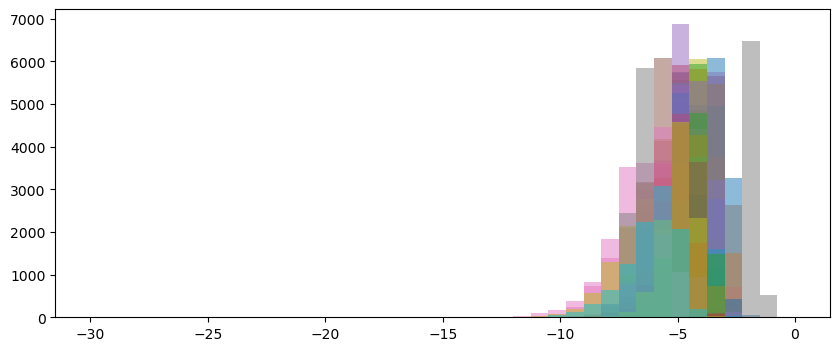

In [73]:
for e in range(60):
    plt.hist(np.log(p_theta[e,:]), bins=40, range=(-30,0), alpha=0.5)
    print(np.sum(p_theta[e,:]))
#plt.hist((p_theta[-2,:]), bins=40, alpha=0.5)

-0.25366616134238706
100.12518452183602


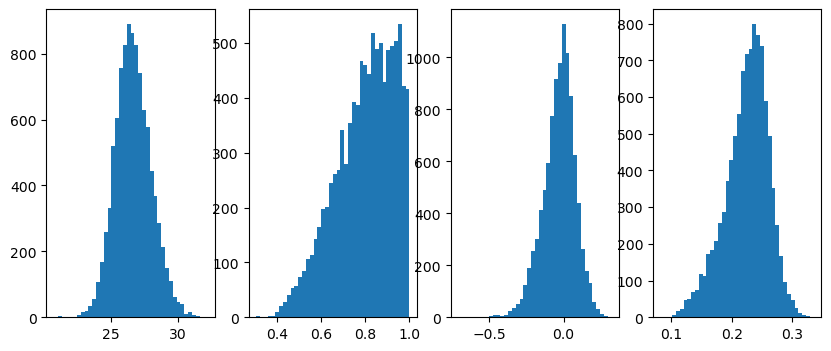

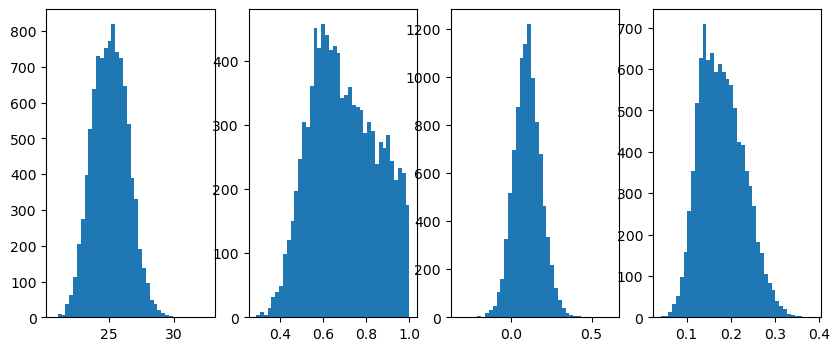

In [75]:
plt.rcParams["figure.figsize"] = (10,4)
for e in range(2):
    fig,ax=plt.subplots(1,4)
    for i in range(4):
        ax[i].hist(obsdata[-e,:,i], bins=40)
    print(np.mean(likelihoods[-e,:]))

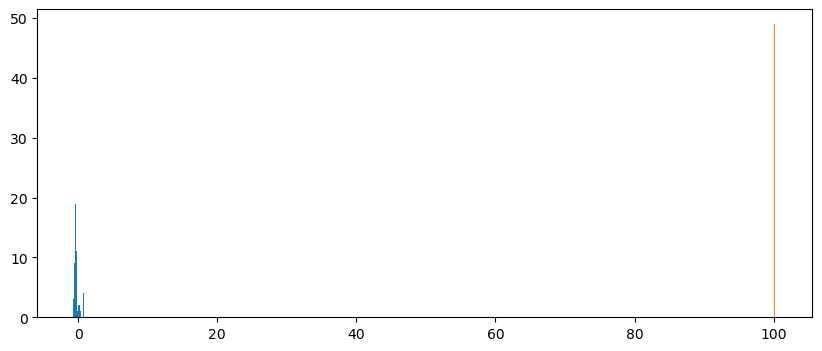

4.381132150025236e-05
1e-50


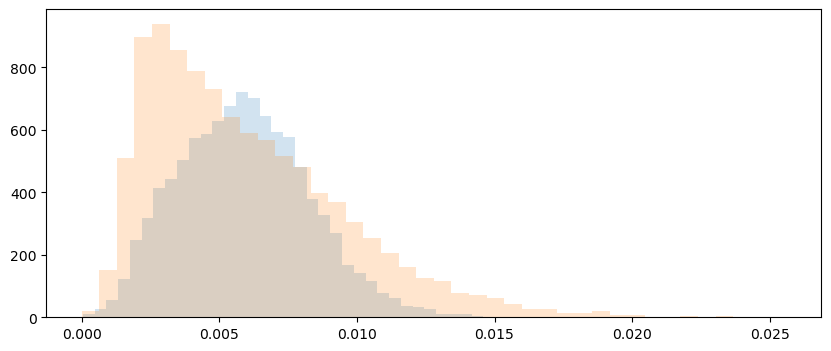

In [84]:
for e in range(2):
    plt.hist(likelihoods[-e,:])
plt.show()
for e in range(2):
    plt.hist(p_theta[-e,:], bins=40, alpha=0.2)
    print(np.min(p_theta[-e,:]))

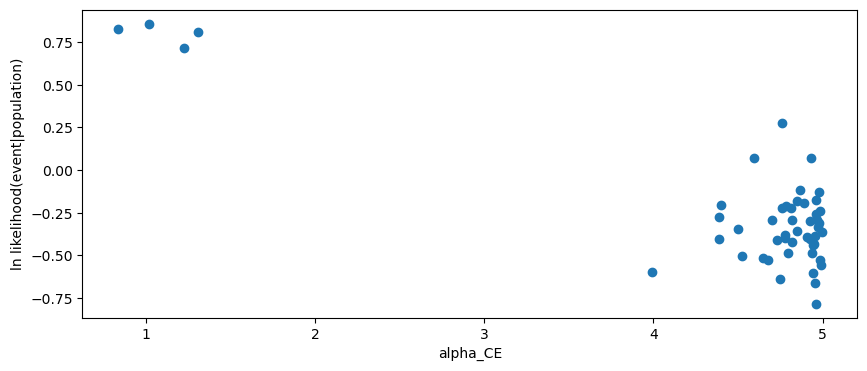

In [85]:
#plt.scatter(hyperpost_samps[random_samp_idxs][:,1], likelihoods_10000Nsamp)
plt.scatter(hyperpost_samps[random_samp_idxs][:,1], likelihoods[0,:])
plt.xlabel('alpha_CE')
plt.ylabel('ln likelihood(event|population)')
#plt.yscale('log')
plt.show()

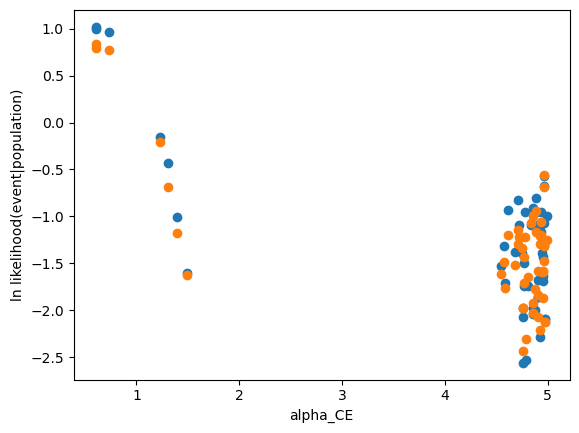

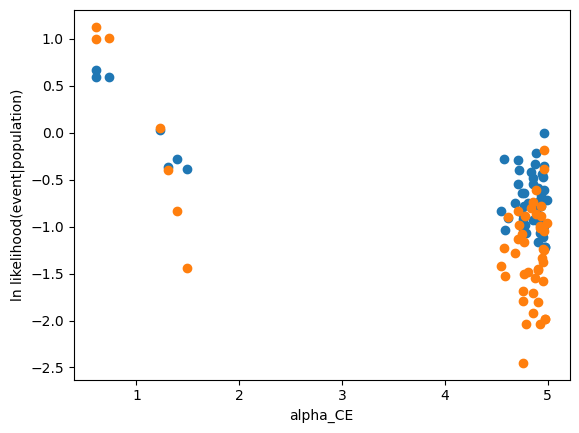

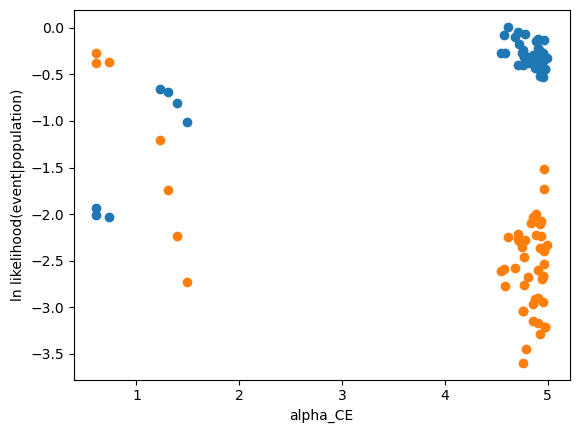

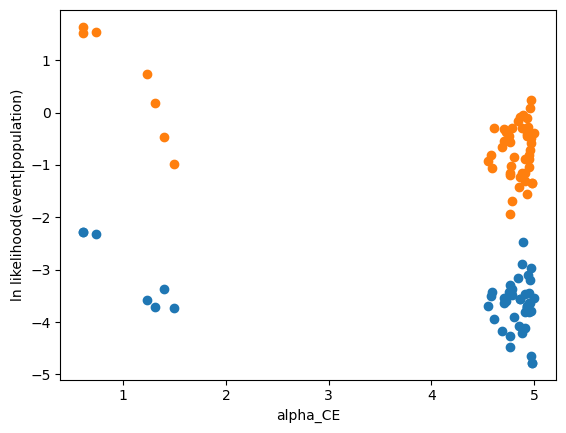

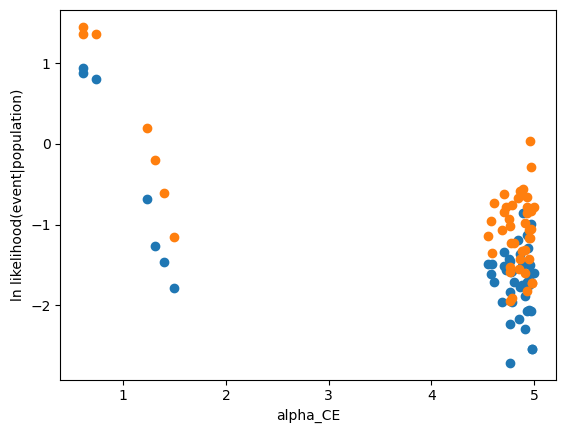

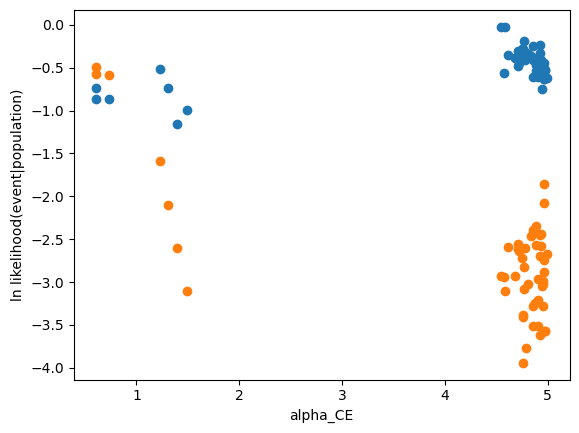

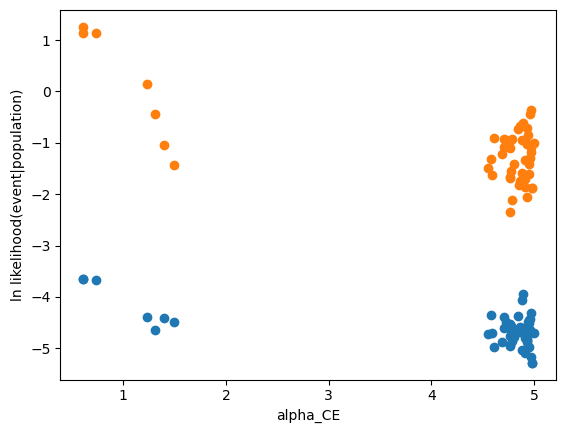

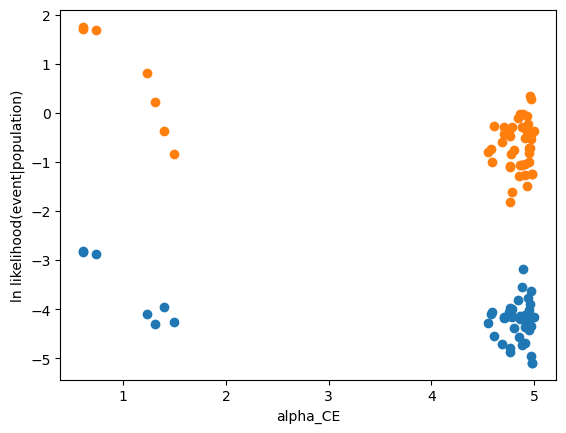

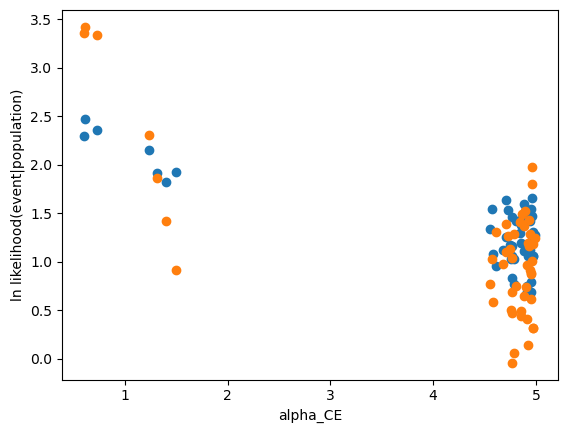

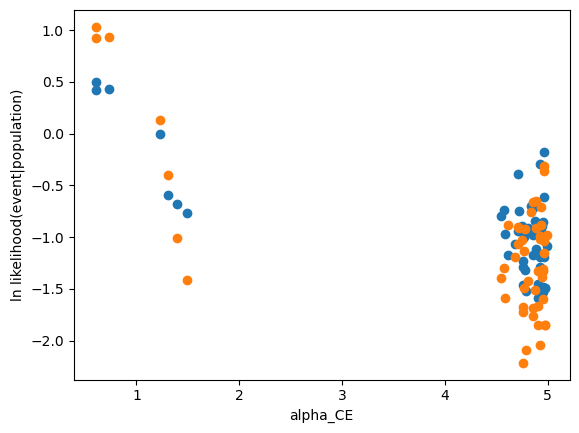

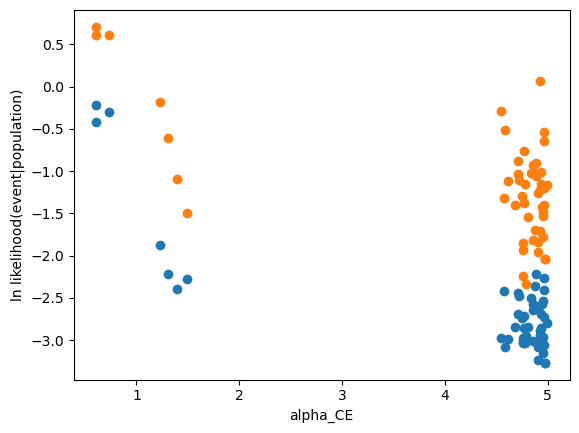

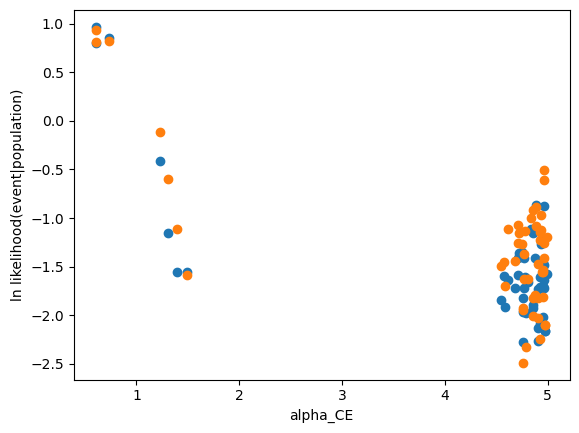

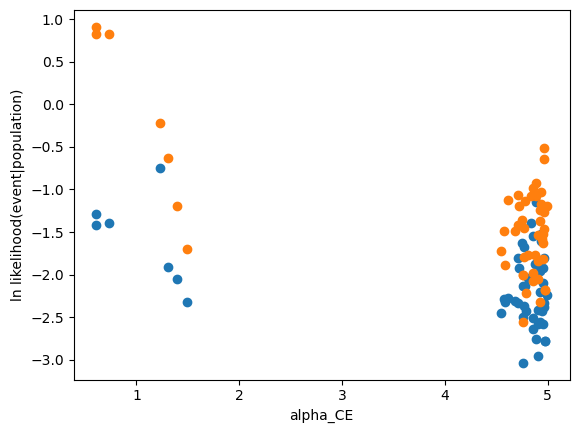

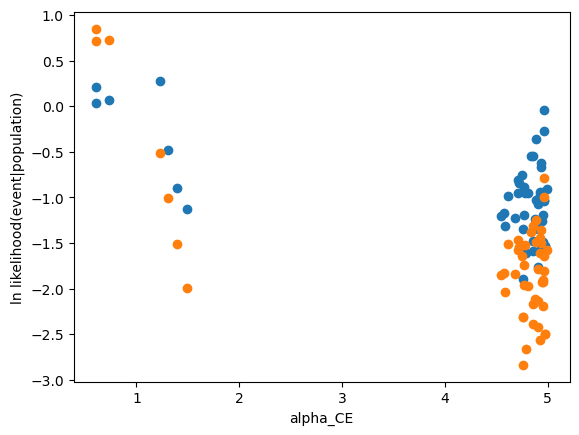

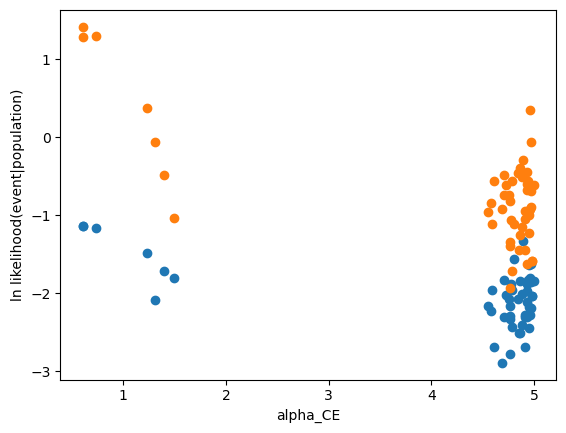

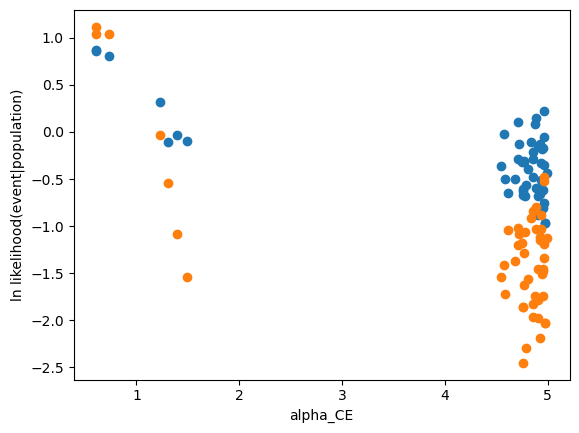

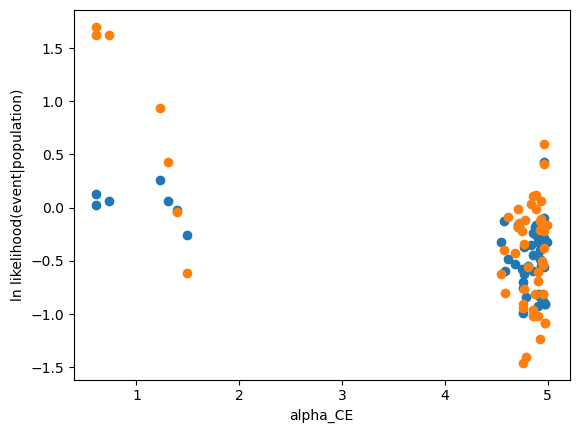

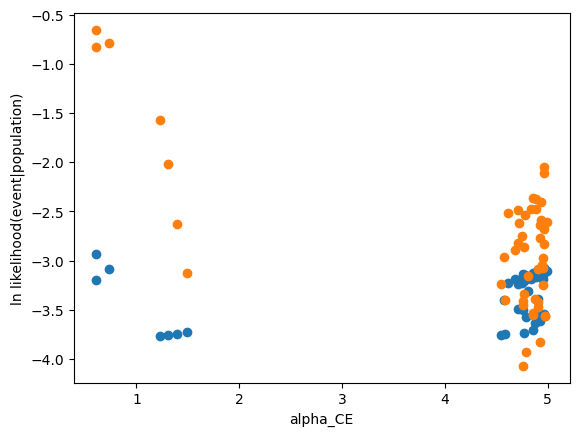

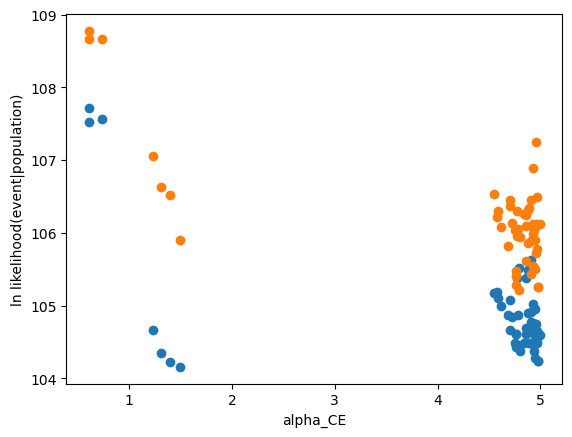

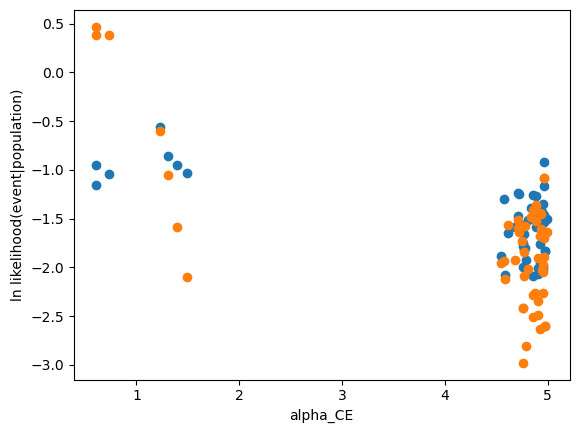

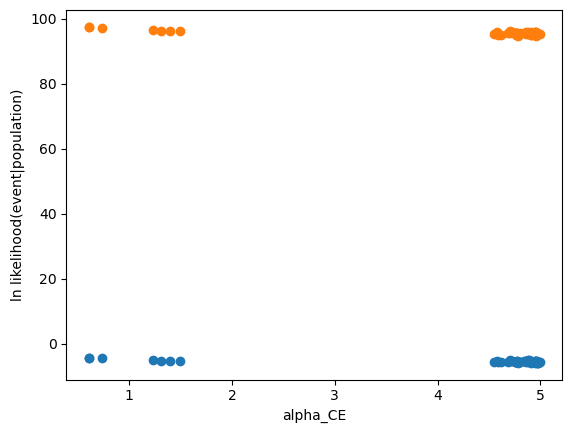

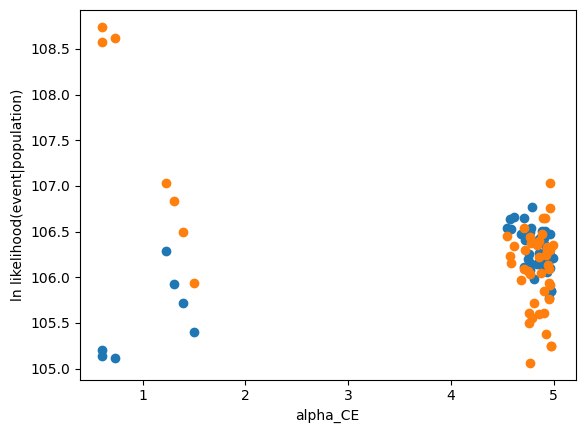

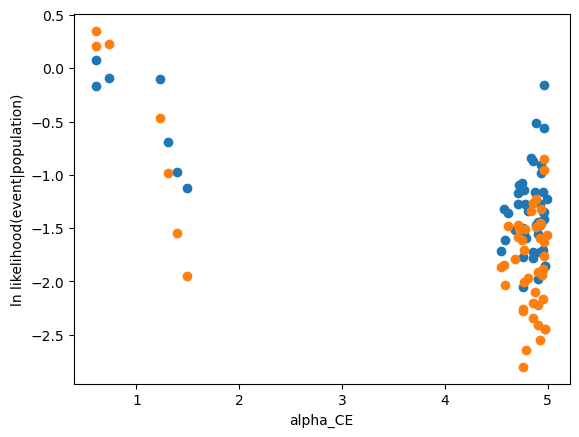

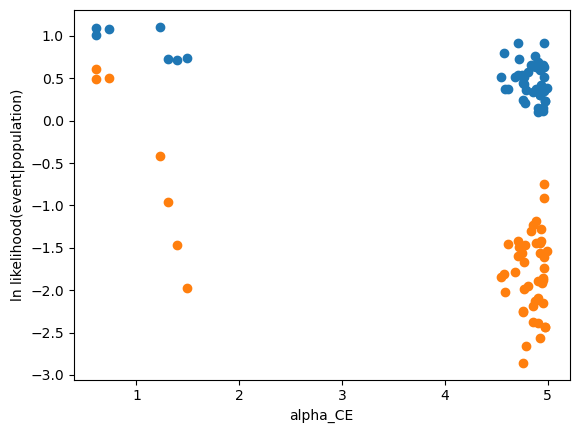

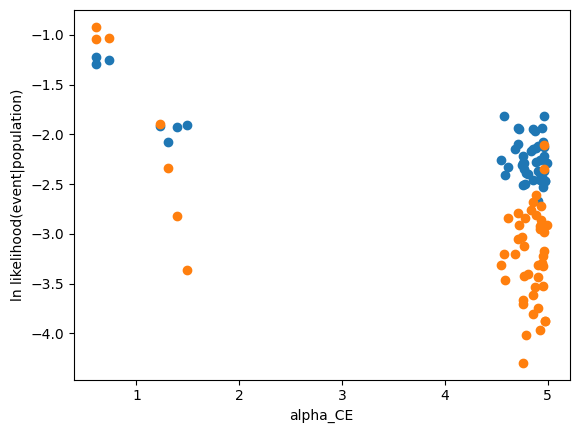

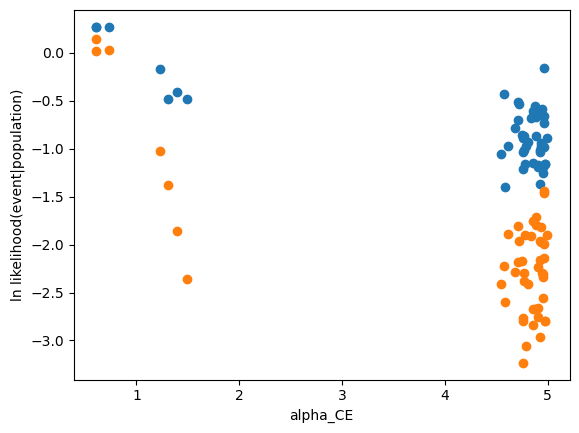

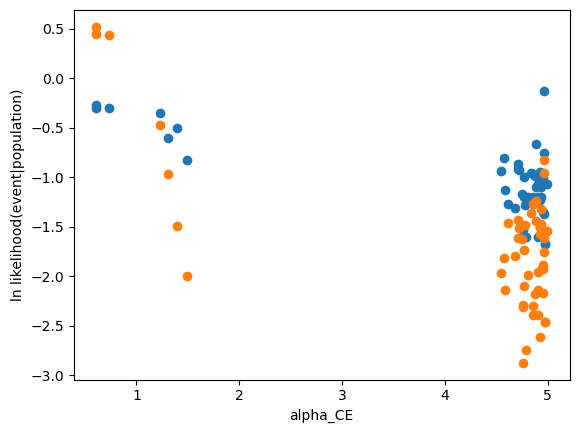

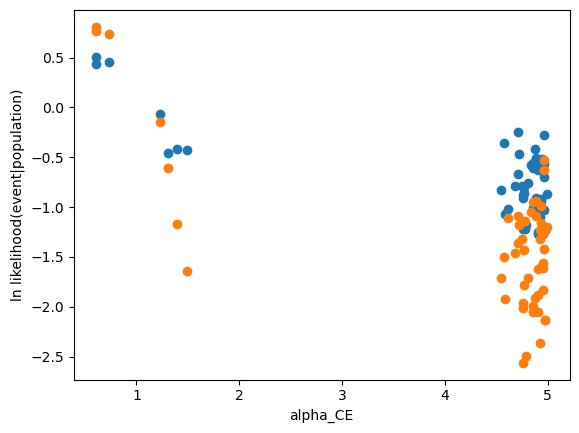

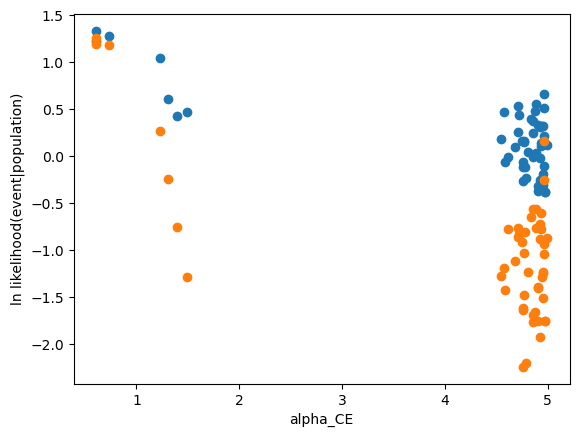

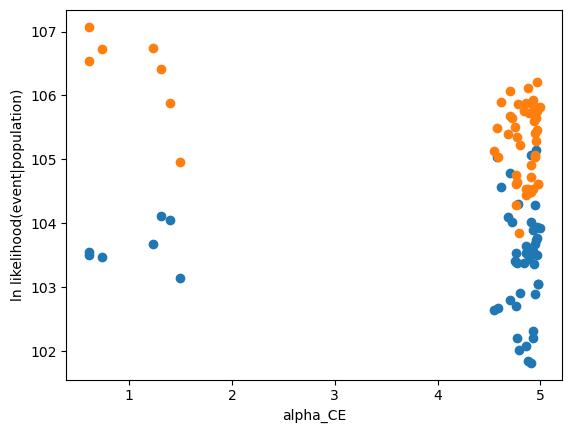

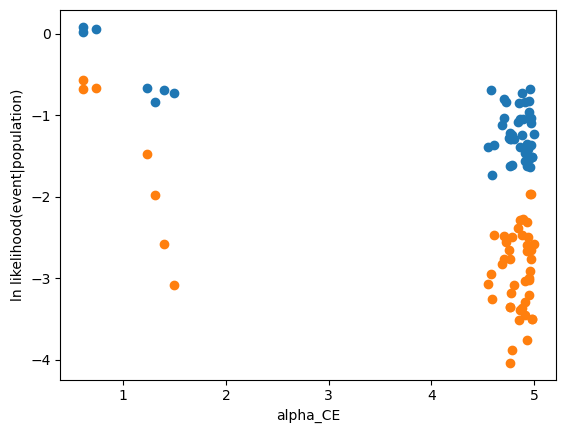

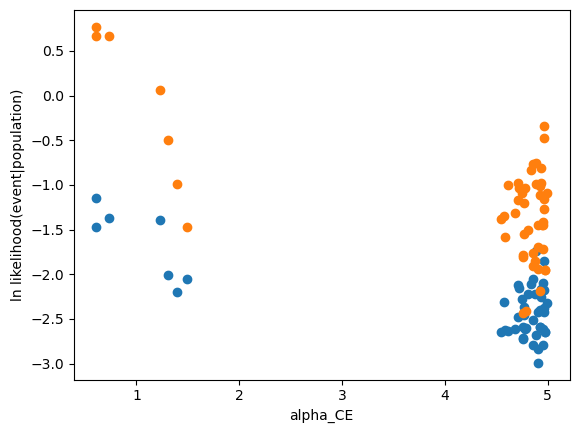

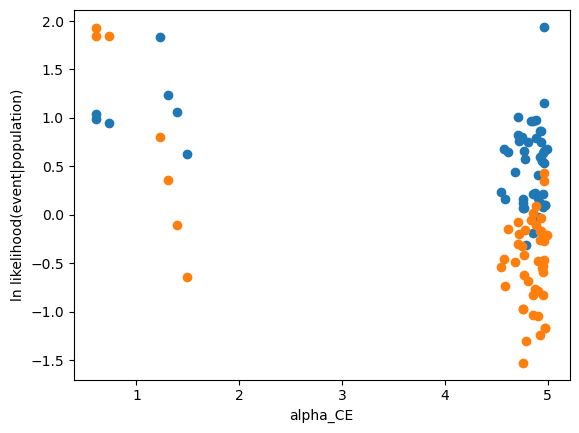

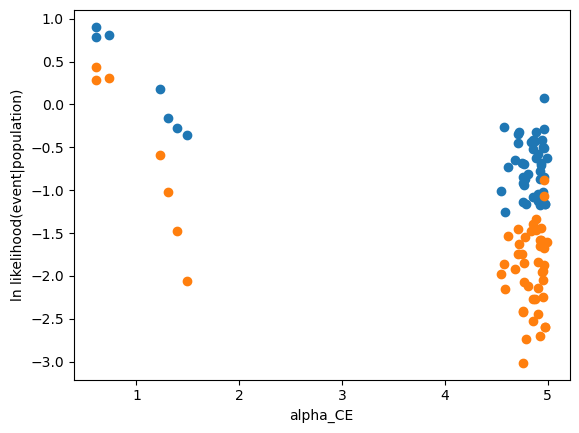

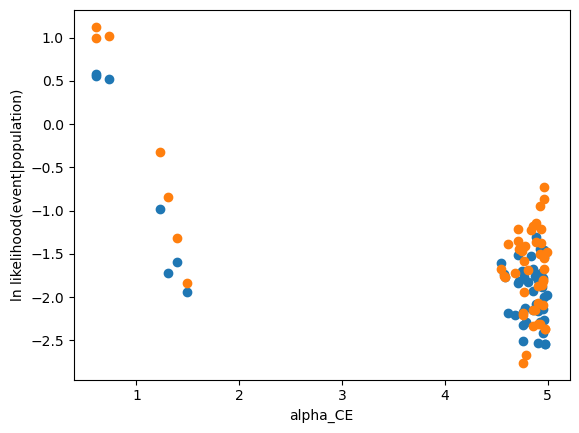

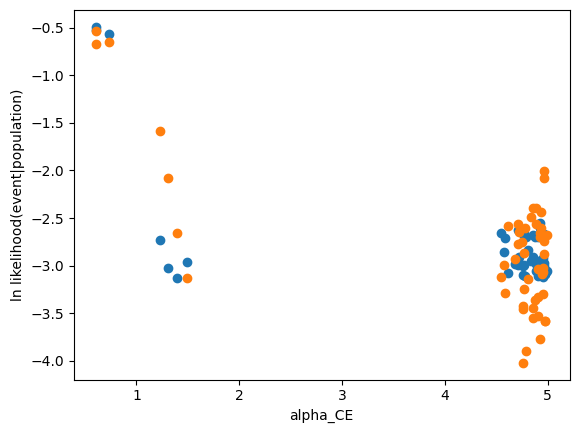

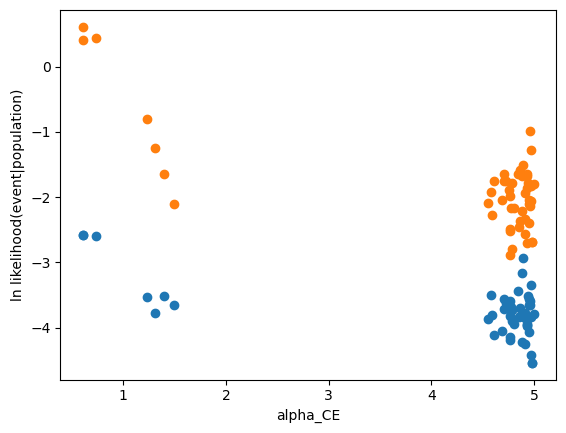

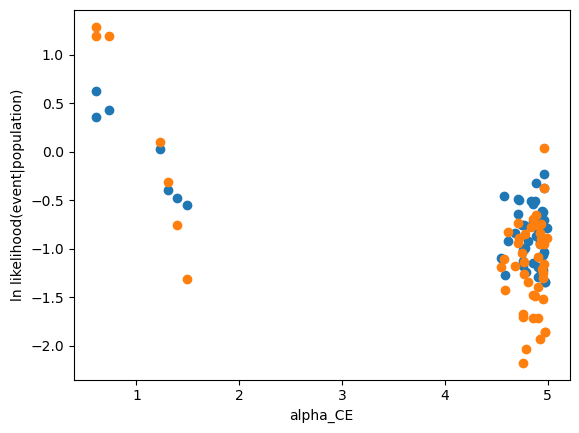

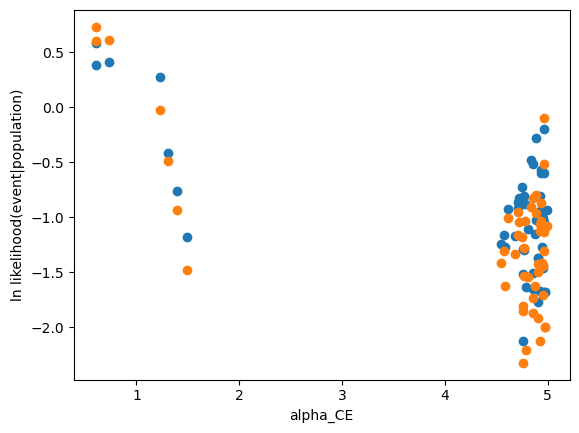

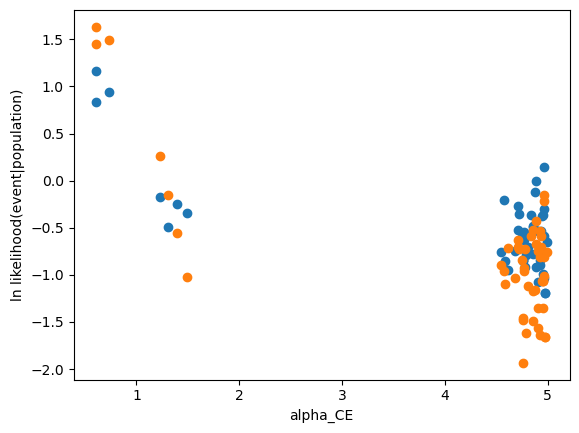

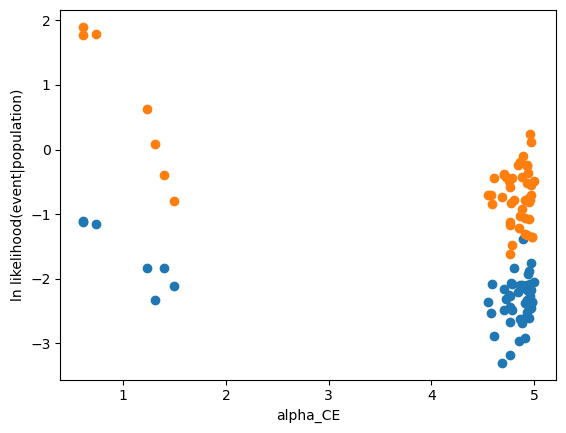

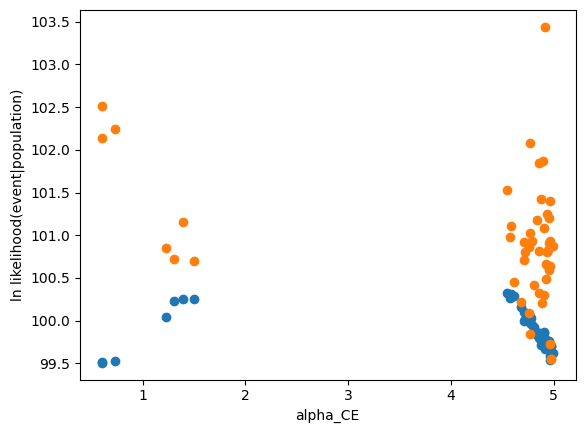

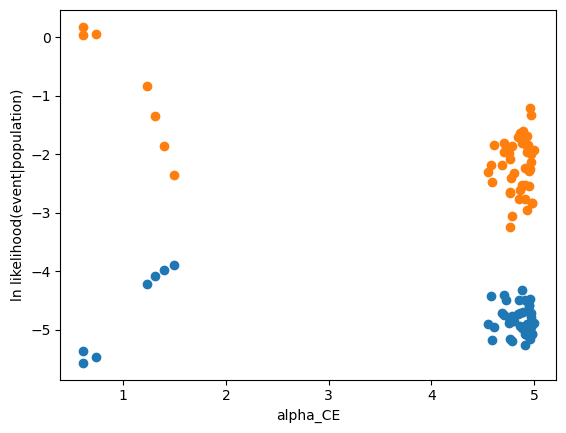

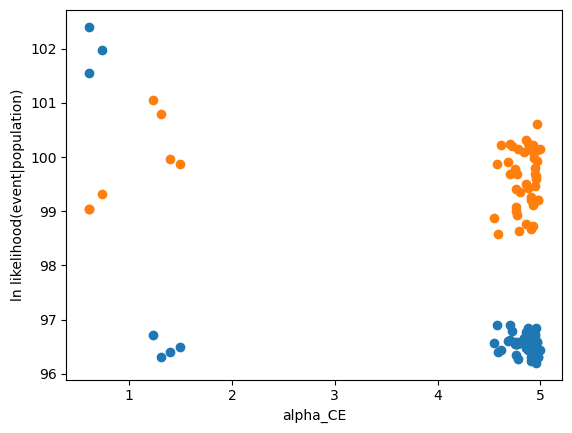

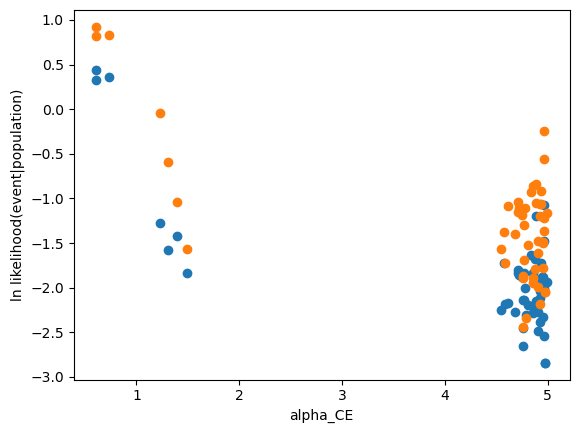

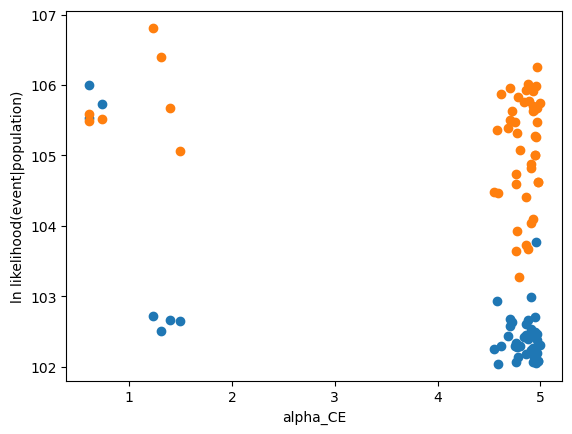

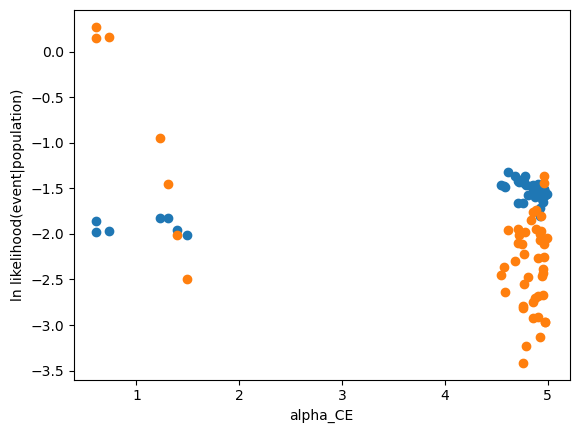

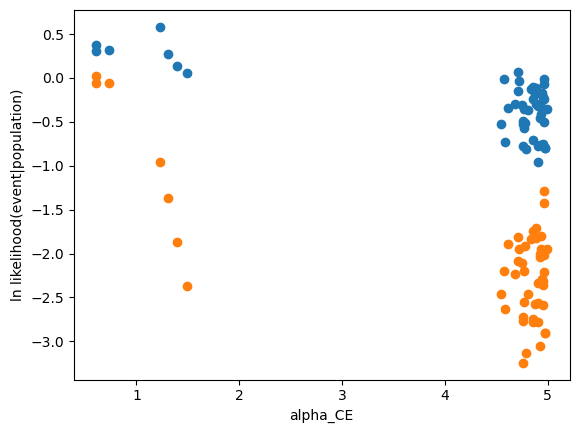

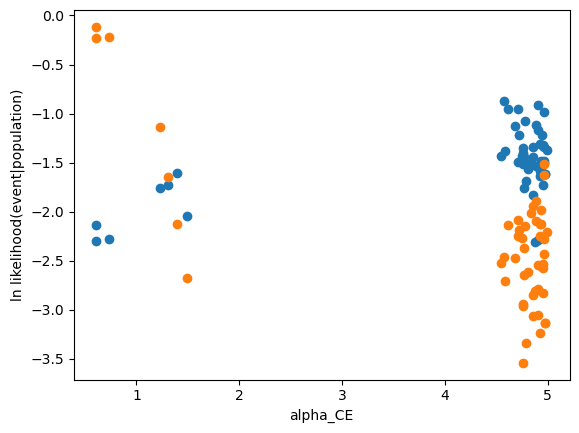

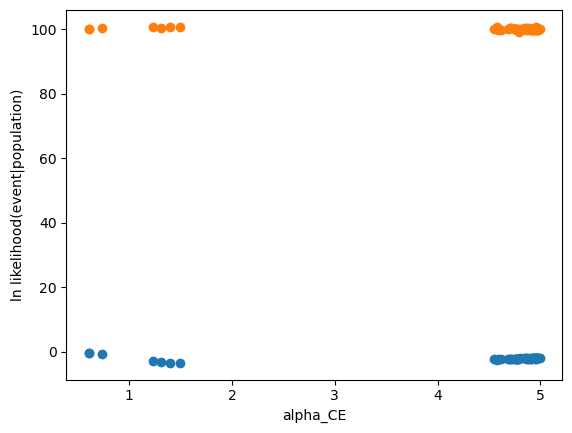

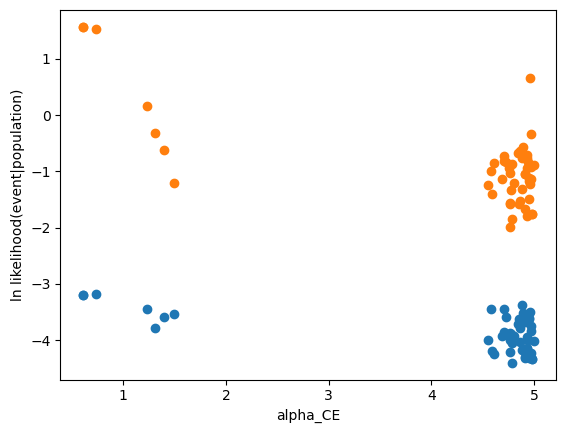

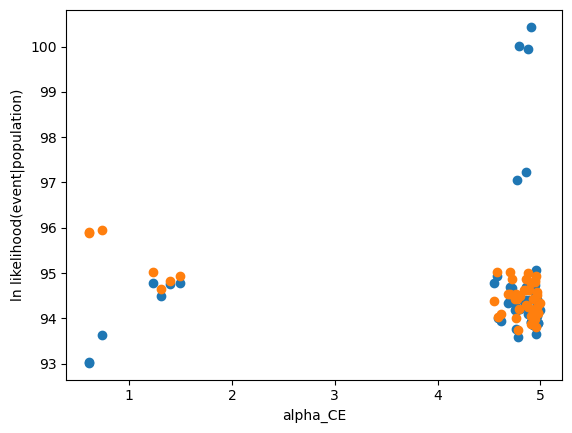

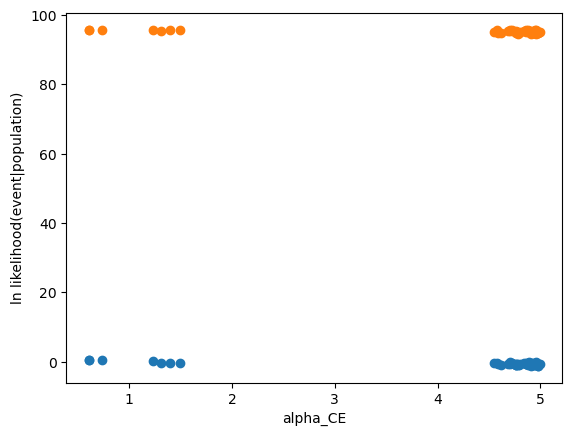

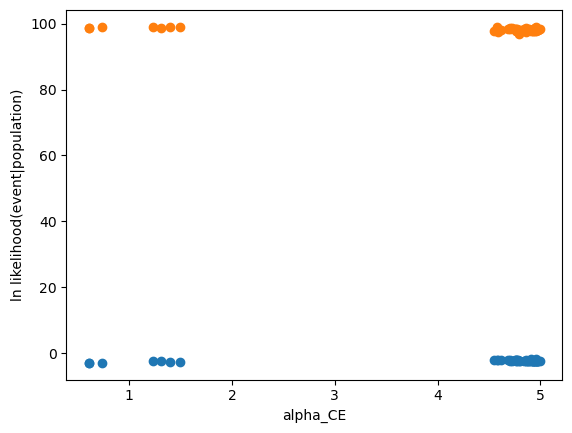

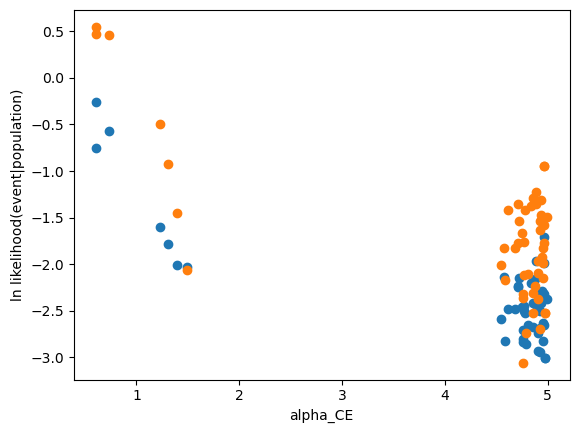

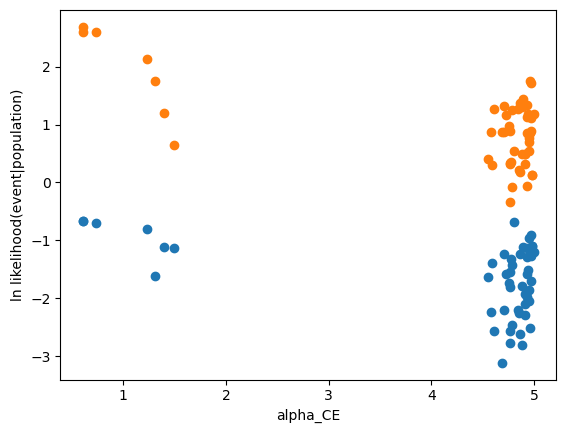

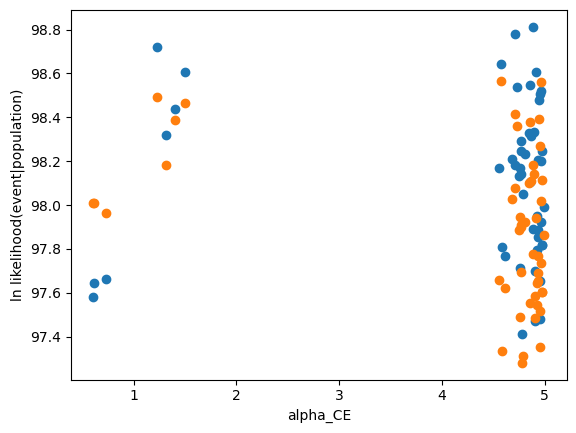

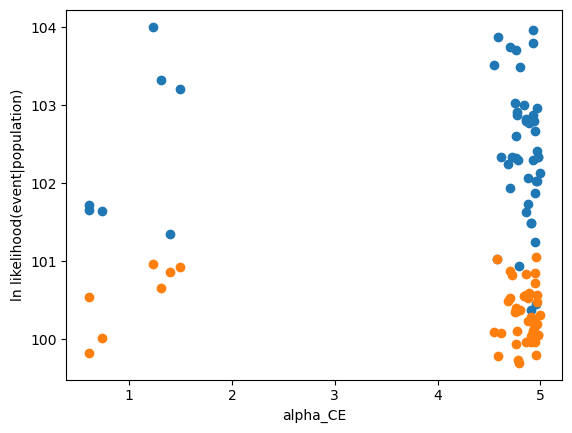

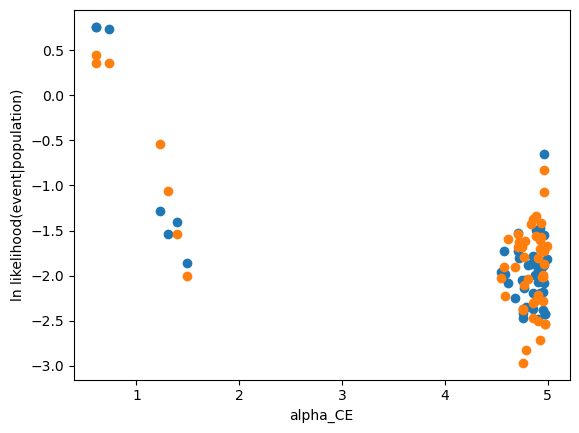

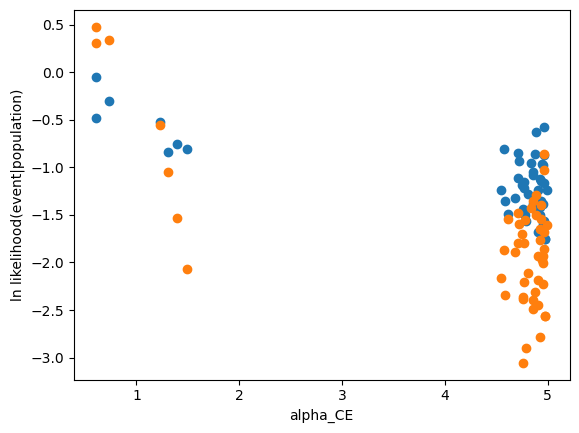

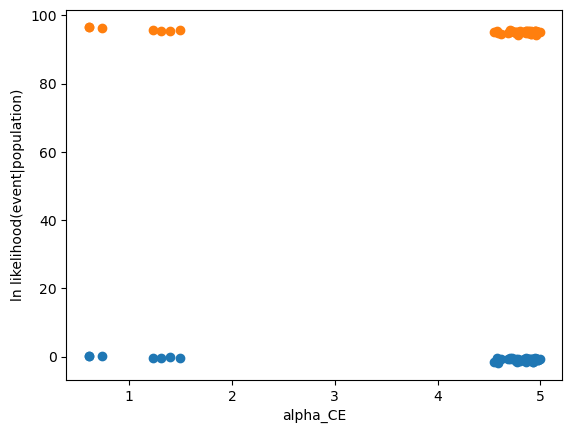

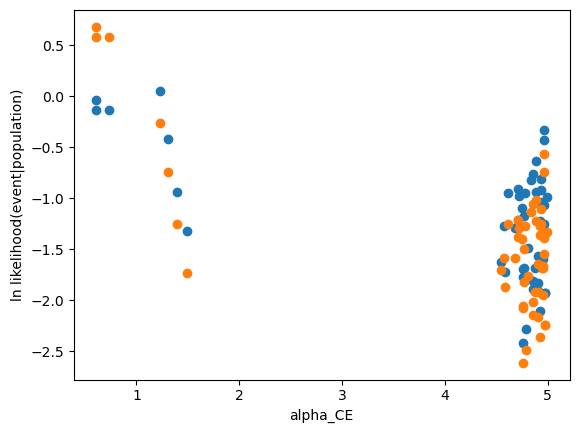

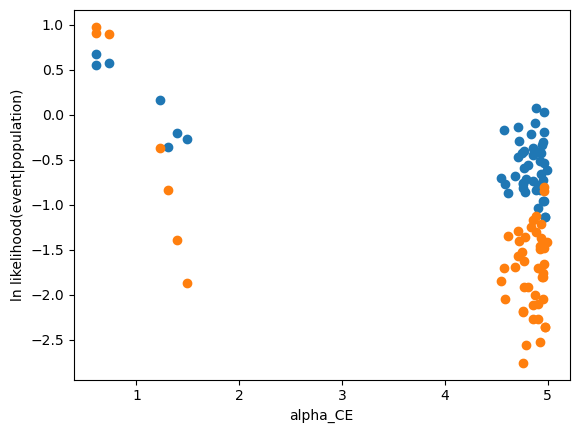

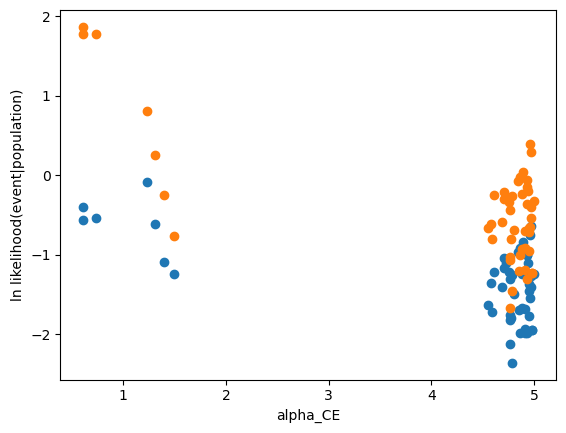

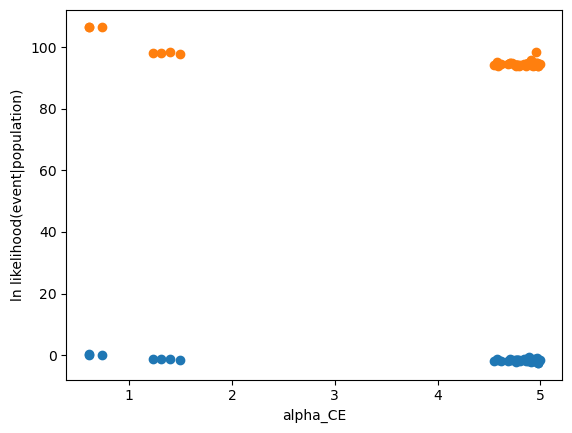

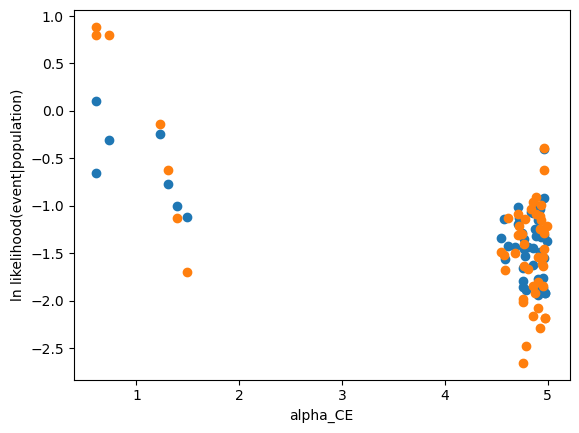

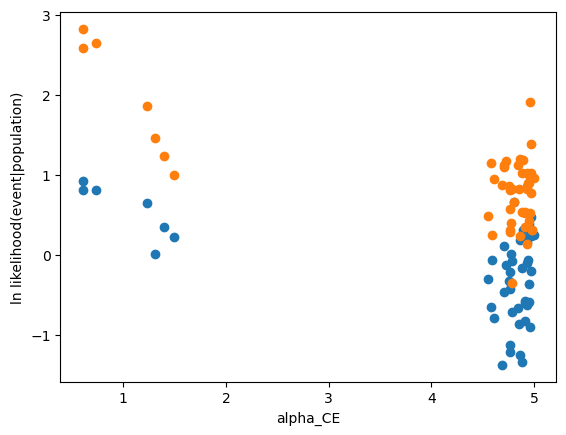

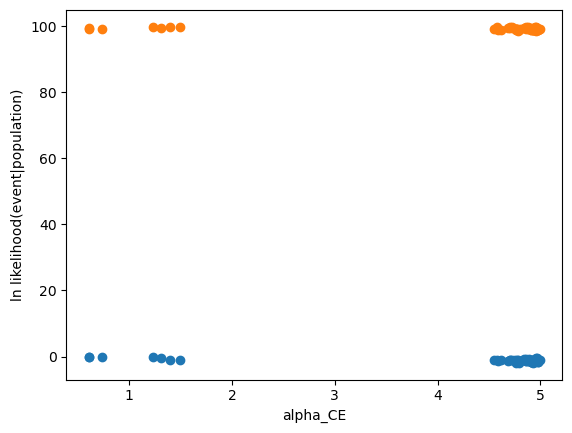

In [76]:
for e, event in enumerate(obsdata):
    plt.scatter(hyperpost_samps[random_samp_idxs][:,1], likelihoods[e,:])
    plt.xlabel('alpha_CE')
    plt.ylabel('ln likelihood(event|population)')
    #plt.yscale('log')
    plt.show()

In [7]:
likelihoods_noprior = np.zeros((68, 10))
observations, obsdata, p_theta, events = gw_obs.generate_observations(params, gw_path, \
                                            100, 'posteriors', 'p_theta')

for i, sampler_hyperposts in tqdm(enumerate(hyperpost_samps[random_samp_idxs[:10]])):
    for e, event in enumerate(obsdata):
        event_shaped = np.reshape(event,(1,100,4))
        likelihoods_noprior[e,i] = sample.lnlike(sampler_hyperposts, event_shaped, flow, submodels_dict, channels, p_theta[e,:], use_flows=True, smallest_N=1000)

10it [00:51,  5.19s/it]


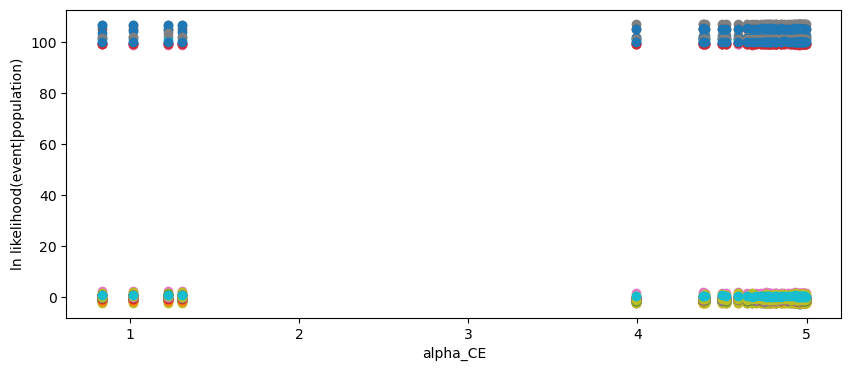

In [87]:
for e, event in enumerate(obsdata):
    plt.scatter(hyperpost_samps[random_samp_idxs][:,1], likelihoods[e,:])
    plt.xlabel('alpha_CE')
    plt.ylabel('ln likelihood(event|population)')
    #plt.yscale('log')
    #plt.show()

Text(0, 0.5, 'sum(log likelihood/prior)')

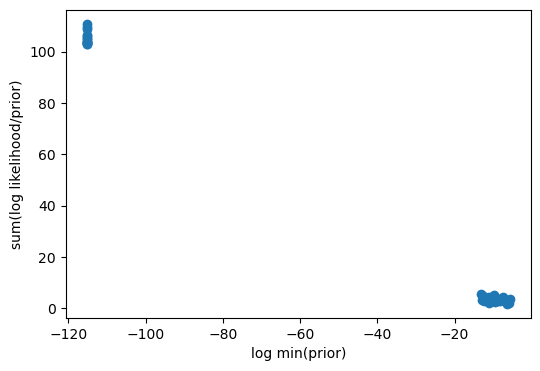

In [96]:
likelihood_sum = []
prior_sum = []
prior_min = []
plt.rcParams["figure.figsize"] = (6,4)
for e in range(len(obsdata[:,0,0])):
    likelihood_sum.append(np.sum(np.exp(likelihoods[e,:])))
    prior_sum.append(np.sum(p_theta[e,:]))
    prior_min.append(np.min(p_theta[e,:]))

plt.scatter(np.log(prior_min), np.log(likelihood_sum))
plt.xlabel('log min(prior)')
plt.ylabel('sum(log likelihood/prior)')

Text(0.5, 0, 'sum(prior)')

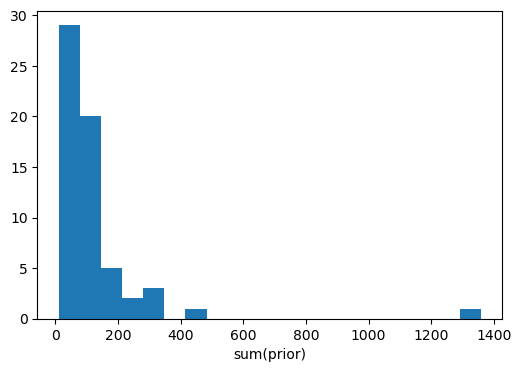

In [101]:
plt.hist(prior_sum, bins=20)
plt.xlabel('sum(prior)')

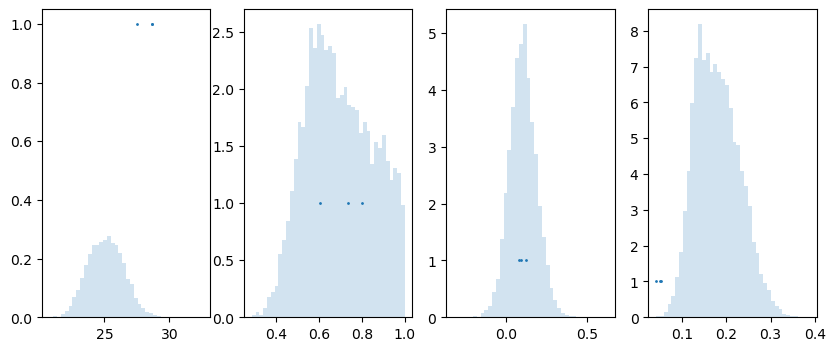

In [125]:
plt.rcParams["figure.figsize"] = (10,4)
fig,ax=plt.subplots(1,4)
for i in range(4):
    ax[i].scatter(obsdata[-1,p_theta[-1,:]==1e-50,i], [1.,1.,1.], s=1.)
    ax[i].hist(obsdata[-1,:,i], bins=40,alpha=0.2, density=True)


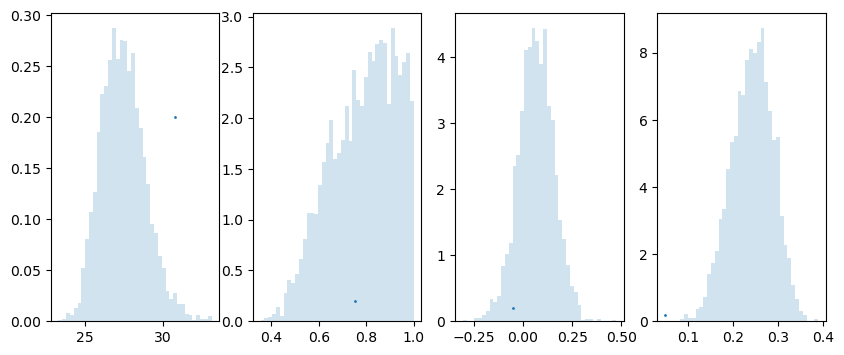

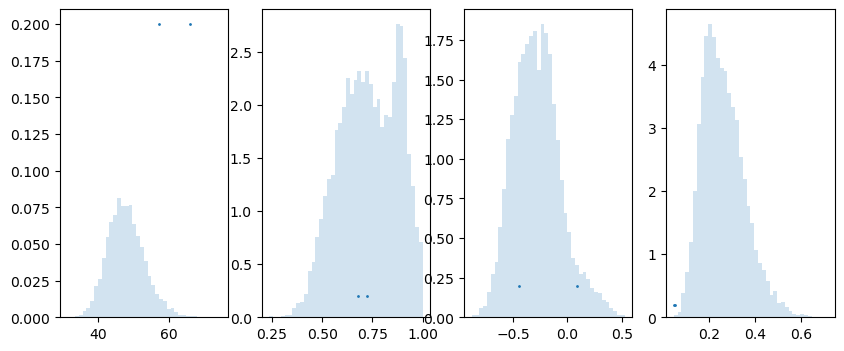

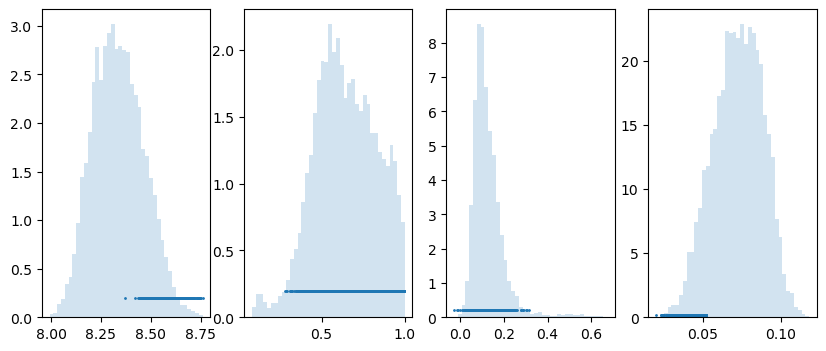

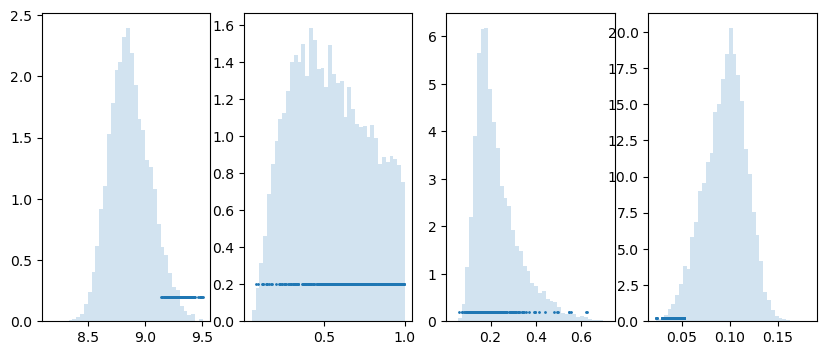

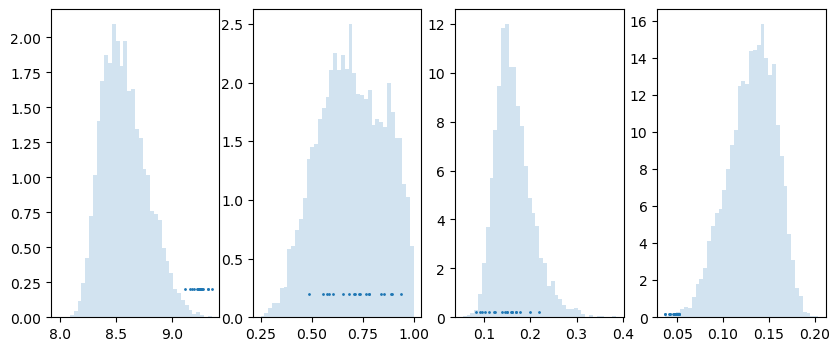

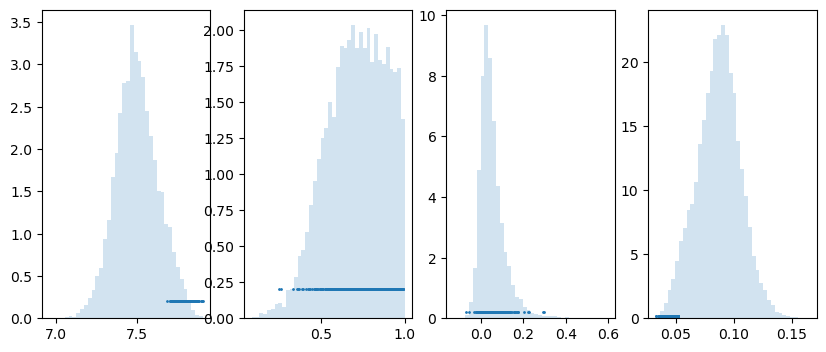

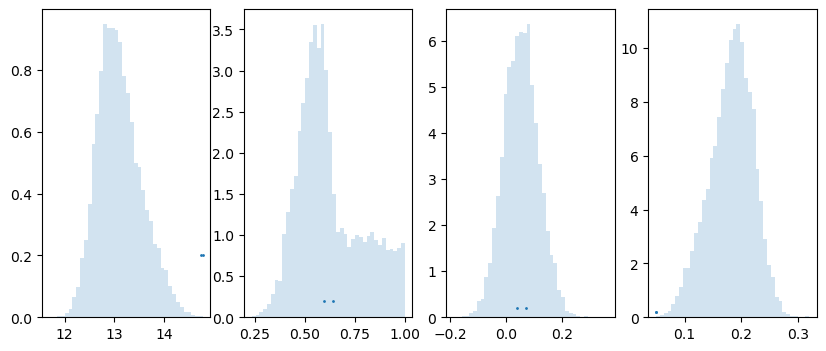

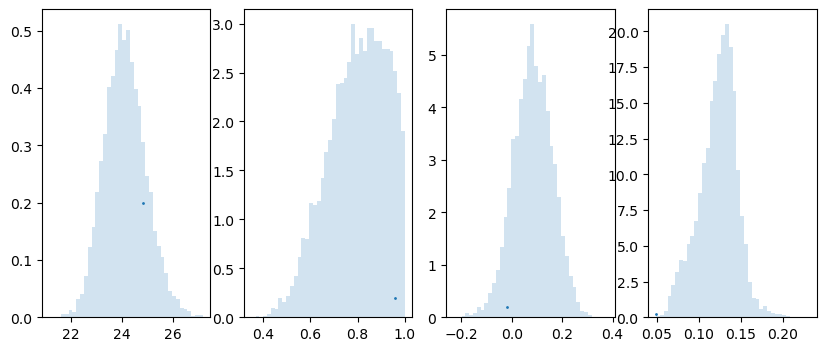

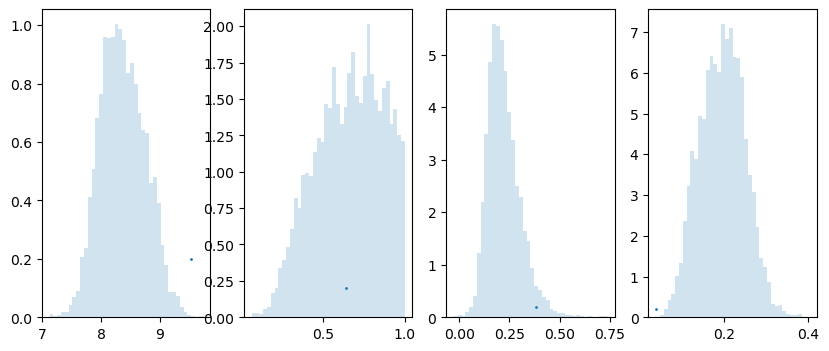

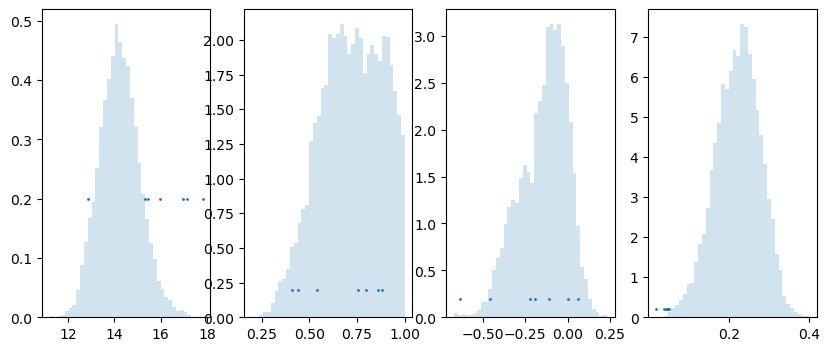

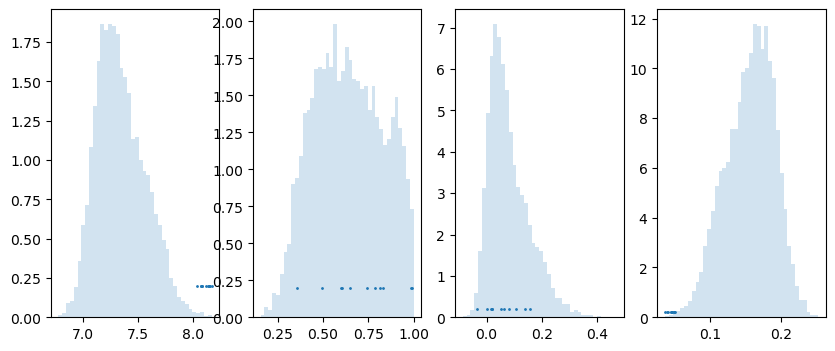

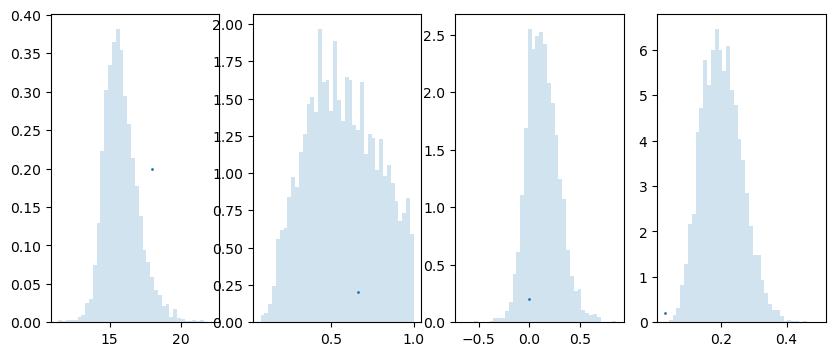

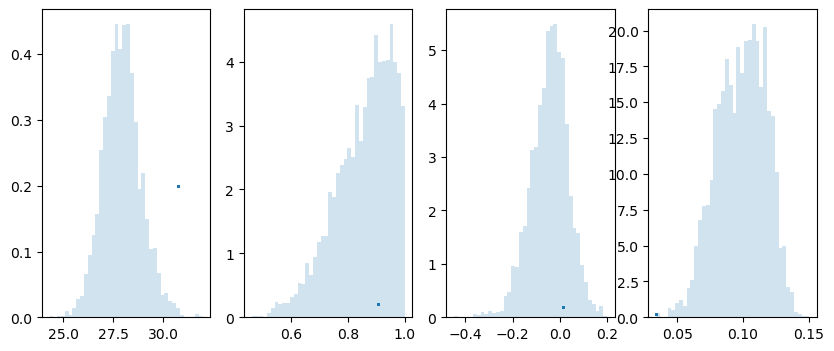

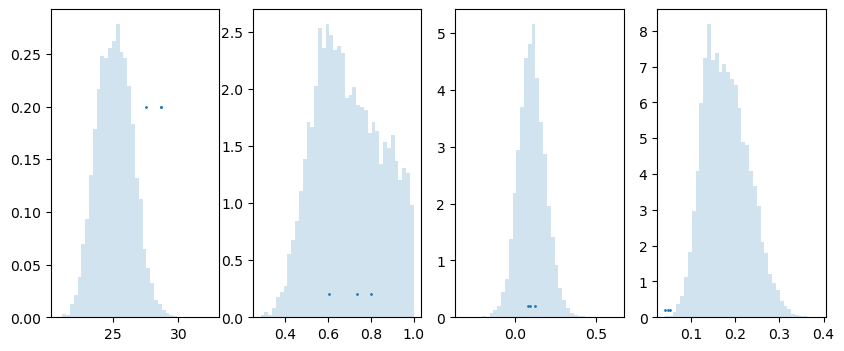

In [177]:
for event_idx in np.where(likelihoods[:,0]>80.)[0]:
    fig,ax=plt.subplots(1,4)
    for i in range(4):
        ax[i].scatter(obsdata[event_idx,p_theta[event_idx,:]<1e-50,i], 0.2*np.ones(len(obsdata[event_idx,p_theta[event_idx,:]<1e-50,i])), s=1.)
        ax[i].hist(obsdata[event_idx,:,i], bins=40,alpha=0.2, density=True)

In [178]:
for event_idx in np.where(likelihoods[:,0]>80.)[0]:
    print(event_idx)
    print(p_theta[event_idx,np.where(obsdata[event_idx,:,3]<0.06)])
    print(obsdata[event_idx,np.where(obsdata[event_idx,:,3]<0.06),3])

13
[[0.]]
[[0.04811757]]
16
[[1.06519294e-04 0.00000000e+00 1.53748797e-05 0.00000000e+00
  5.50089537e-05]]
[[0.0569139  0.04430975 0.05801189 0.04920414 0.05686444]]
17
[[0.00338842 0.00409398 0.         ... 0.00330719 0.00384214 0.        ]]
[[0.05220055 0.05874368 0.02386598 ... 0.05797281 0.05981989 0.04825656]]
25
[[0.00271314 0.         0.00226557 0.         0.         0.00315914
  0.         0.         0.00299673 0.         0.         0.00299044
  0.00148154 0.         0.00242924 0.         0.00268874 0.
  0.         0.00330097 0.00209764 0.00288371 0.         0.00286069
  0.00223395 0.00301223 0.00296612 0.         0.         0.
  0.00280195 0.00181663 0.         0.         0.00315476 0.00181786
  0.         0.00287928 0.00191265 0.00273192 0.00219598 0.
  0.00255597 0.00232626 0.         0.         0.         0.00270636
  0.00206002 0.00202034 0.00225731 0.00181736 0.         0.
  0.         0.         0.00212422 0.00196364 0.         0.
  0.         0.00245807 0.         0.0

In [131]:
np.where(likelihoods[:,0]>80.)

(array([13, 16, 17, 25, 37, 40, 44, 45, 46, 49, 50, 53, 57, 60]),)